In [68]:
!git clone https://github.com/weirdfish23/pest-insects-GAN.git

Cloning into 'pest-insects-GAN'...
remote: Enumerating objects: 282, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 282 (delta 14), reused 31 (delta 14), pack-reused 251
Receiving objects: 100% (282/282), 1.72 GiB | 39.33 MiB/s, done.
Resolving deltas: 100% (130/130), done.
Checking out files: 100% (102/102), done.


In [69]:
%cd pest-insects-GAN/

/content/pest-insects-GAN/pest-insects-GAN


In [70]:
!pip install -r requirements.txt

In [ ]:
!pip install universal-divergence

  Created wheel for universal-divergence: filename=universal_divergence-0.2.0-cp37-none-any.whl size=2831 sha256=af40d971c5eb9ff7909b69887dc4f762bce3a918a17bc79299a1bfe35a7ad860
  Stored in directory: /root/.cache/pip/wheels/8a/a0/ab/1aae4a117337edafc4ad5d24340cb381487d23b35dc1ed75f3
Successfully built universal-divergence


In [211]:
import torch
import os
import random
import wandb
import numpy as np
import seaborn as sns
import pandas as pd
import gdown
import zipfile
import shutil
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from skimage import io
import matplotlib.pyplot as plt
import colorsys
#import universal_divergence

from utils.dataloader import InsectsDataset, ToTensorNorm
from utils.imgs import show_tensor_images
from utils.read import read_config


In [72]:
!mkdir data

## Dataset

In [73]:
!python3 dowload_base_data.py

Downloading...
From: https://drive.google.com/uc?id=1WZq21C4O6c4KwjSFFTxHzMGzM9zYtPhW
To: /content/pest-insects-GAN/pest-insects-GAN/data/dataset_v0.zip
12.1MB [00:00, 104MB/s] 


In [74]:
!python3 traditional_data_augmentation.py

Augmenting liriomyza huidobrensis ...
# of new augmented samples per original image: 23
100% 112/112 [00:03<00:00, 37.03it/s]
Augmenting brevicoryne brassicae ...
# of new augmented samples per original image: 23
100% 58/58 [00:01<00:00, 37.84it/s]
Augmenting prodiplosis longifila ...
# of new augmented samples per original image: 23
100% 35/35 [00:00<00:00, 38.19it/s]
Augmenting trips tabaci ...
# of new augmented samples per original image: 23
100% 53/53 [00:01<00:00, 38.51it/s]
Augmenting Bemisia tabaci ...
# of new augmented samples per original image: 0
100% 5807/5807 [00:06<00:00, 948.75it/s]
Augmenting Macrolophus pygmaeus ...
# of new augmented samples per original image: 0
100% 1619/1619 [00:01<00:00, 920.77it/s]
Augmenting Nesidiocoris tenuis ...
# of new augmented samples per original image: 1
100% 688/688 [00:01<00:00, 459.50it/s]


In [75]:
config = read_config()

base_path = os.path.join(config['base_data']['dest_dir'], 'augmented')
csv_file = os.path.join(base_path, 'data_info.csv')
root_dir = os.path.join(base_path, 'images')

In [76]:
dataset = InsectsDataset(csv_file=csv_file, root_dir=root_dir, transform=ToTensorNorm(), return_one_hot=True)

In [77]:
classes = dataset.label_binarizer.classes_
classes

array(['Bemisia tabaci', 'Macrolophus pygmaeus', 'Nesidiocoris tenuis',
       'brevicoryne brassicae', 'liriomyza huidobrensis',
       'prodiplosis longifila', 'trips tabaci'], dtype='<U22')

In [78]:
for spec in classes:
  lbl_bin = dataset.label_binarizer.transform([spec])
  print(spec, '::')
  print(lbl_bin)

Bemisia tabaci ::
[[1 0 0 0 0 0 0]]
Macrolophus pygmaeus ::
[[0 1 0 0 0 0 0]]
Nesidiocoris tenuis ::
[[0 0 1 0 0 0 0]]
brevicoryne brassicae ::
[[0 0 0 1 0 0 0]]
liriomyza huidobrensis ::
[[0 0 0 0 1 0 0]]
prodiplosis longifila ::
[[0 0 0 0 0 1 0]]
trips tabaci ::
[[0 0 0 0 0 0 1]]


## Load conditional DCGAN

In [10]:
from models.conditional_GAN import Generator, Discriminator, get_noise, get_one_hot_labels, combine_vectors, get_input_dimensions
#torch.backends.cudnn.deterministic = True

In [11]:
generator_input_dim, discriminator_im_chan = 71, 10
device = 'cuda'
lr= 0.002

gen_dcgan = Generator(input_dim=generator_input_dim).to(device)

In [12]:
!ls weights/conditional_DCGAN_18_04_21__12_23_09

conditional_DCGAN_disc_state_epoch_100	conditional_DCGAN_gen_state_epoch_100
conditional_DCGAN_disc_state_epoch_200	conditional_DCGAN_gen_state_epoch_200
conditional_DCGAN_disc_state_epoch_300	conditional_DCGAN_gen_state_epoch_300


In [13]:
gen_ws = torch.load("weights/conditional_DCGAN_18_04_21__12_23_09/conditional_DCGAN_gen_state_epoch_300")

In [14]:
gen_dcgan.load_state_dict(gen_ws['state_dict'])
gen_dcgan = gen_dcgan.eval()

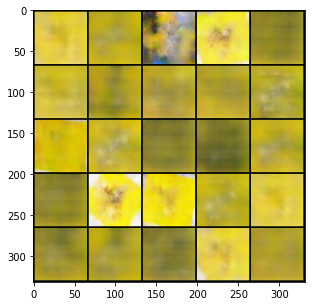

In [15]:
#@title Generar imágenes { run: "auto" }
# r_seed = 486 #@param {type:"slider", min:0, max:1000, step:1}
# random.seed(r_seed)
# np.random.seed(r_seed)
# torch.manual_seed(r_seed)
# torch.cuda.manual_seed_all(r_seed)


fake_noise = get_noise(25, 64, device='cuda')
lbl = torch.tensor([[0, 0, 0, 0, 0, 0, 0]], device='cuda')
lbl = lbl.repeat(25, 1)

idx = 2 #@param {type:"slider", min:0, max:6, step:1}
# best class: 4, r_seed: 486
lbl[:][idx] = 1 

noise_and_labels = combine_vectors(fake_noise, lbl)
fake = gen_dcgan(noise_and_labels)
plt.figure(figsize = (5,5))
a = show_tensor_images(fake, num_images=25, nrow=5)

## Load Conditional WGAN

In [16]:
from models.conditional_WGAN import Generator, Critic, get_noise, get_one_hot_labels, combine_vectors, get_input_dimensions

In [17]:
generator_input_dim, critic_im_chan = 71, 10
device = 'cuda'
lr= 0.002

gen_wgan = Generator(input_dim=generator_input_dim).to(device)

In [18]:
!ls weights/conditional_WGAN_19_04_21__21_45_07

conditional_WGAN_crit_state_epoch_100  conditional_WGAN_gen_state_epoch_100
conditional_WGAN_crit_state_epoch_200  conditional_WGAN_gen_state_epoch_200
conditional_WGAN_crit_state_epoch_300  conditional_WGAN_gen_state_epoch_300
conditional_WGAN_crit_state_epoch_400  conditional_WGAN_gen_state_epoch_400


In [19]:
gen_ws = torch.load("weights/conditional_WGAN_19_04_21__21_45_07/conditional_WGAN_gen_state_epoch_400")

In [20]:
gen_wgan.load_state_dict(gen_ws['state_dict'])
gen_wgan = gen_wgan.eval()

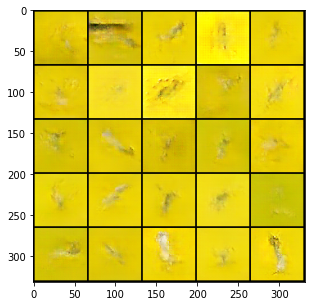

In [21]:
#@title Generar imágenes { run: "auto" }
fake_noise = get_noise(25, 64, device='cuda')
lbl = torch.tensor([[0, 0, 0, 0, 0, 0, 0]], device='cuda')
lbl = lbl.repeat(25, 1)

idx = 1 #@param {type:"slider", min:0, max:6, step:1}
# best class: 4, r_seed: 486
lbl[:,idx] = 1 
#print(lbl)

noise_and_labels = combine_vectors(fake_noise, lbl)
#print(noise_and_labels[0])
fake = gen_wgan(noise_and_labels)

plt.figure(figsize = (5,5))
a = show_tensor_images(fake, num_images=25, nrow=5)

## Load VAE Condicional

In [79]:
from models.conditionalVAE import Decoder, Encoder, get_noise, reparameterize, get_one_hot_labels, combine_vectors, get_input_dimensions, loss_function


In [80]:
decoder_input_dim= 71
device = 'cuda'

dec = Decoder(input_dim=decoder_input_dim).to(device)

In [81]:
!ls weights/conditional_VAE_23_04_21__14_36_25

conditional_VAE_dec_state_epoch_100  conditional_VAE_enc_state_epoch_100
conditional_VAE_dec_state_epoch_200  conditional_VAE_enc_state_epoch_200
conditional_VAE_dec_state_epoch_300  conditional_VAE_enc_state_epoch_300
conditional_VAE_dec_state_epoch_400  conditional_VAE_enc_state_epoch_400
conditional_VAE_dec_state_epoch_500  conditional_VAE_enc_state_epoch_500


In [82]:
dec_ws = torch.load("weights/conditional_VAE_23_04_21__14_36_25/conditional_VAE_dec_state_epoch_500")

In [83]:
dec.load_state_dict(dec_ws['state_dict'])
dec = dec.eval()

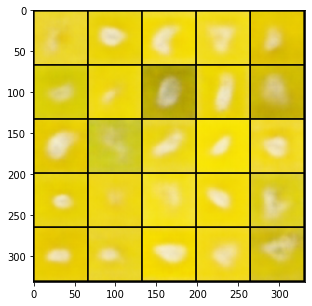

In [84]:
#@title Generar imágenes { run: "auto" }
fake_noise = get_noise(25, 64, device='cuda')
lbl = torch.tensor([[0, 0, 0, 0, 0, 0, 0]], device='cuda')
lbl = lbl.repeat(25, 1)

idx = 0 #@param {type:"slider", min:0, max:6, step:1}
# best class: 4, r_seed: 486
lbl[:,idx] = 1 
#print(lbl)

noise_and_labels = combine_vectors(fake_noise, lbl)
#print(noise_and_labels[0])
fake = dec(noise_and_labels)

plt.figure(figsize = (5,5))
a = show_tensor_images(fake, num_images=25, nrow=5)

## Pipeline

In [207]:
classes_to_generate = ['liriomyza huidobrensis',
                       'brevicoryne brassicae',
                       'prodiplosis longifila',
                       'trips tabaci',
                       'Bemisia tabaci',
                       'Macrolophus pygmaeus',
                       'Nesidiocoris tenuis']
tots_range_per_class = {
    'liriomyza huidobrensis': [10, 20] ,
    'brevicoryne brassicae': [0, 5] ,
    'prodiplosis longifila': [10, 20] ,
    'trips tabaci': [10, 20] ,
    'Bemisia tabaci': [10, 20] ,
    'Macrolophus pygmaeus': [10, 20] ,
    'Nesidiocoris tenuis': [10, 20] 
}
original_dimensions = {
    'liriomyza huidobrensis': 64 ,
    'brevicoryne brassicae': 64 ,
    'prodiplosis longifila': 64 ,
    'trips tabaci': 64 ,
    'Bemisia tabaci': 64 ,
    'Macrolophus pygmaeus': 64 ,
    'Nesidiocoris tenuis': 64 
}
selected_generator = {
    'liriomyza huidobrensis': 'DCGAN',
    'brevicoryne brassicae': 'WGAN',
    'prodiplosis longifila':  'VAE',
    'trips tabaci': 'VAE',
    'Bemisia tabaci':  'VAE',
    'Macrolophus pygmaeus': 'DCGAN',
    'Nesidiocoris tenuis': 'WGAN'
}
gen_imgs_ratio = 0.2
insects_tfs = None
additional_noise_imgs = None
add_noise_imgs_prob = None

In [86]:
sample_img = dataset[1200]['image']

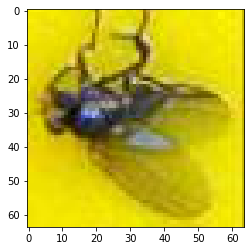

In [87]:
sample_img = (sample_img + 1) / 2
plt.imshow(sample_img.permute(1, 2, 0).squeeze())
plt.show()

### Load templates

In [88]:
templates_url = 'https://drive.google.com/uc?id=1By6xig_XqM9LSFeBn0GOcrjyDs2vc4uK'

In [89]:
def download_templates(dest_dir, src_filename, data_url):

    if src_filename in os.listdir(dest_dir):
        os.remove(os.path.join(dest_dir, src_filename))

    gdown.download(data_url, os.path.join(dest_dir, src_filename, ), quiet=False)

    if 'templates' in os.listdir(dest_dir):
        shutil.rmtree(os.path.join(dest_dir, 'templates'))
    
    with zipfile.ZipFile(os.path.join(dest_dir, src_filename),"r") as zip_ref:
        zip_ref.extractall(os.path.join(dest_dir, 'templates'))

    os.remove(os.path.join(dest_dir, src_filename))

In [90]:
download_templates('data', 'templates_sticky_traps.zip', templates_url)

Downloading...
From: https://drive.google.com/uc?id=1By6xig_XqM9LSFeBn0GOcrjyDs2vc4uK
To: /content/pest-insects-GAN/pest-insects-GAN/data/templates_sticky_traps.zip
152MB [00:01, 150MB/s]


In [91]:
len(os.listdir('data/templates/templates_sticky_traps'))

285

In [92]:
templates_dir = 'data/templates/templates_sticky_traps'

In [93]:
templates_files = files_images = list(filter(lambda x: x.split('.')[-1]=='jpg', os.listdir('data/templates/templates_sticky_traps')))
templates_files.sort()
len(templates_files)

284

In [176]:
def rgb_to_hsv(rgb):
    # Translated from source of colorsys.rgb_to_hsv
    # r,g,b should be a numpy arrays with values between 0 and 255
    # rgb_to_hsv returns an array of floats between 0.0 and 1.0.
    rgb = rgb.astype('float')
    hsv = np.zeros_like(rgb)
    # in case an RGBA array was passed, just copy the A channel
    hsv[..., 3:] = rgb[..., 3:]
    r, g, b = rgb[..., 0], rgb[..., 1], rgb[..., 2]
    maxc = np.max(rgb[..., :3], axis=-1)
    minc = np.min(rgb[..., :3], axis=-1)
    hsv[..., 2] = maxc
    mask = maxc != minc
    hsv[mask, 1] = (maxc - minc)[mask] / maxc[mask]
    rc = np.zeros_like(r)
    gc = np.zeros_like(g)
    bc = np.zeros_like(b)
    rc[mask] = (maxc - r)[mask] / (maxc - minc)[mask]
    gc[mask] = (maxc - g)[mask] / (maxc - minc)[mask]
    bc[mask] = (maxc - b)[mask] / (maxc - minc)[mask]
    hsv[..., 0] = np.select(
        [r == maxc, g == maxc], [bc - gc, 2.0 + rc - bc], default=4.0 + gc - rc)
    hsv[..., 0] = (hsv[..., 0] / 6.0) % 1.0
    return hsv

def hsv_to_rgb(hsv):
    # Translated from source of colorsys.hsv_to_rgb
    # h,s should be a numpy arrays with values between 0.0 and 1.0
    # v should be a numpy array with values between 0.0 and 255.0
    # hsv_to_rgb returns an array of uints between 0 and 255.
    rgb = np.empty_like(hsv)
    rgb[..., 3:] = hsv[..., 3:]
    h, s, v = hsv[..., 0], hsv[..., 1], hsv[..., 2]
    i = (h * 6.0).astype('uint8')
    f = (h * 6.0) - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))
    i = i % 6
    conditions = [s == 0.0, i == 1, i == 2, i == 3, i == 4, i == 5]
    rgb[..., 0] = np.select(conditions, [v, q, p, p, t, v], default=v)
    rgb[..., 1] = np.select(conditions, [v, v, v, q, p, p], default=t)
    rgb[..., 2] = np.select(conditions, [v, p, t, v, v, q], default=p)
    return rgb.astype('uint8')

def shift_hue(arr,hout):
    hsv=rgb_to_hsv(arr)
    hsv[...,0]=hout
    rgb=hsv_to_rgb(hsv)
    return rgb

In [193]:
def paste_img(template, img, margin, out_hue):
  # correct img hue
  img = torch.tensor(shift_hue(img.permute(1, 2, 0).numpy()*255, out_hue)).permute(2, 0, 1) / 255.0

  im_w = img.shape[2]
  im_h = img.shape[1]
  t_w = template.shape[2]
  t_h = template.shape[1]
  
  x = np.random.randint(0+margin, t_w-im_w-margin)
  y = np.random.randint(0+margin, t_h-im_h-margin)

  template[:, y:y+im_h, x:x+im_w] = img 
  #[xmin, ymin, xmax, ymax]
  bnd_box = [x, y, x+im_w, y+im_h]
  return template, bnd_box

### Pipeline procedure


all_imgs.shape torch.Size([73, 3, 64, 64])
len(all_labels) 73
len(all_flags) 73
len(all_bnd_bxs) 73

all_imgs.shape torch.Size([80, 3, 64, 64])
len(all_labels) 80
len(all_flags) 80
len(all_bnd_bxs) 80

len(tot_templates_filled_names) 153
len(tot_labels) 153
len(tot_flags) 153
len(tot_bnd_bxs) 153


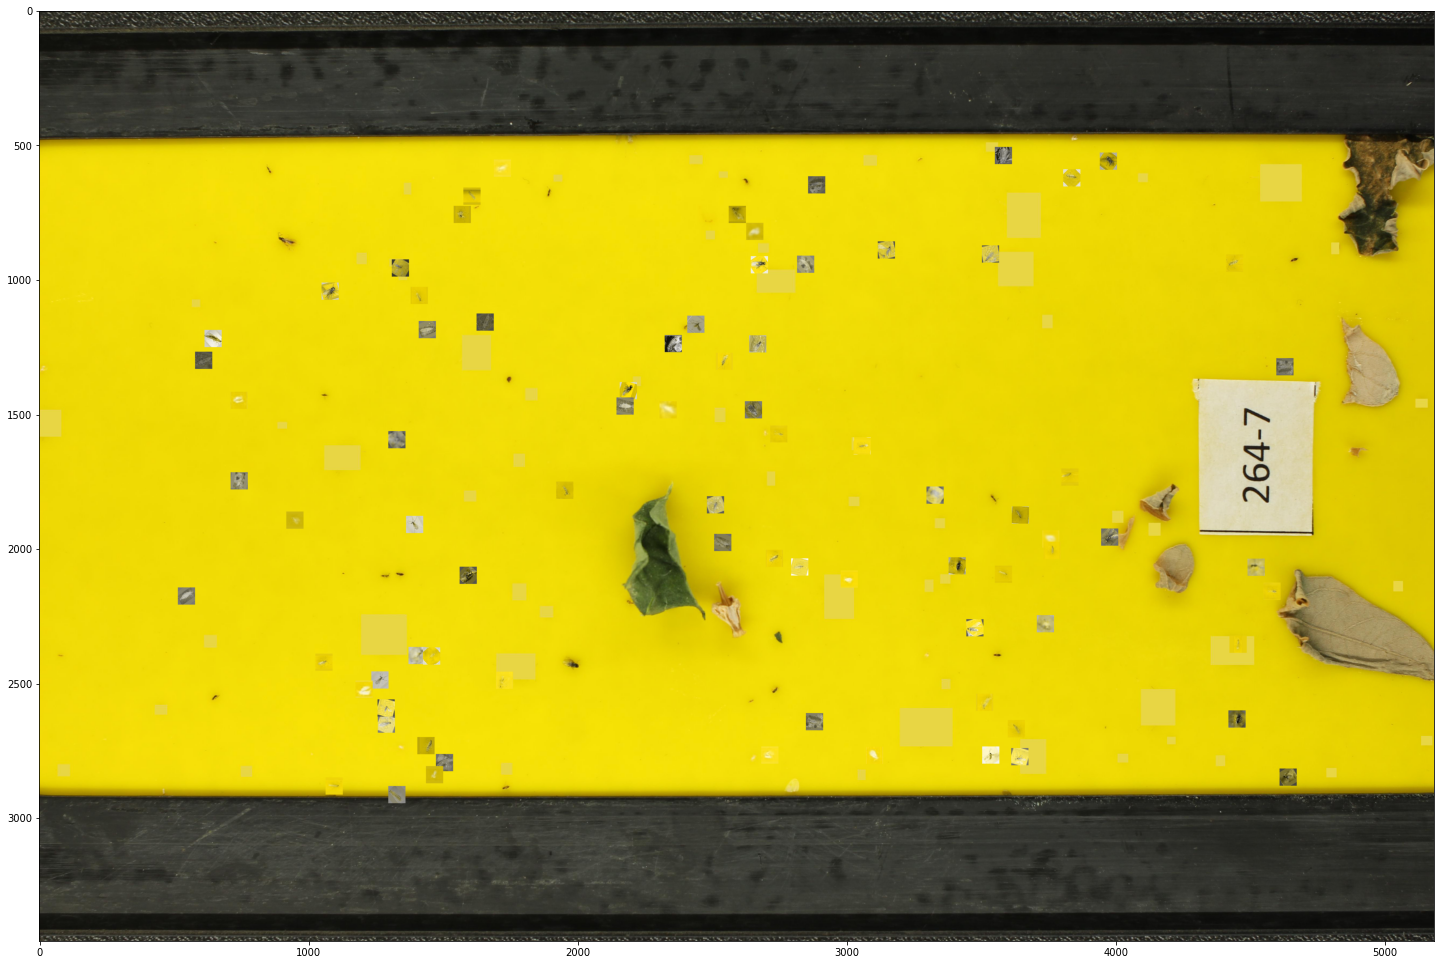

In [208]:
margin = 500
template_hue = 1.47871992e-01

tot_templates_filled_names = []
tot_labels = []
tot_flags = []
tot_bnd_bxs = []

for template in templates_files[:2]:
  # load template image
  temp_img = io.imread(os.path.join(templates_dir, template))
  temp_save_name = template.split('.')[0]+'_filled'+'.jpg'
  temp_img = torch.tensor(temp_img) / 255.0
  temp_img = temp_img.permute(2,0,1)

  all_imgs = []
  all_labels = []
  all_flags = []
  all_bnd_bxs = []

  for spec in classes_to_generate:
    n_orig = np.random.randint(tots_range_per_class[spec][0], tots_range_per_class[spec][1]+1)
    n_gen = int(n_orig*gen_imgs_ratio)
    n_orig -= n_gen

    generated_imgs = None
    original_imgs = None

    # generate imgs
    generator_name = selected_generator[spec]
    if n_gen > 0:
      if generator_name == 'DCGAN':
        fake_noise = get_noise(n_gen, 64, device='cuda')
        lbl = torch.tensor(dataset.label_binarizer.transform([spec]), device='cuda')
        lbl = lbl.repeat(n_gen, 1)
        noise_and_labels = combine_vectors(fake_noise, lbl)
        generated_imgs = gen_dcgan(noise_and_labels).cpu().detach()
        generated_imgs = (generated_imgs+1)/2
      elif generator_name == 'WGAN':
        fake_noise = get_noise(n_gen, 64, device='cuda')
        lbl = torch.tensor(dataset.label_binarizer.transform([spec]), device='cuda')
        lbl = lbl.repeat(n_gen, 1)
        noise_and_labels = combine_vectors(fake_noise, lbl)
        generated_imgs = gen_wgan(noise_and_labels).cpu().detach()
        generated_imgs = (generated_imgs+1)/2
      elif generator_name == 'VAE':
        fake_noise = get_noise(n_gen, 64, device='cuda')
        lbl = torch.tensor(dataset.label_binarizer.transform([spec]), device='cuda')
        lbl = lbl.repeat(n_gen, 1)
        noise_and_labels = combine_vectors(fake_noise, lbl)
        generated_imgs = dec(noise_and_labels).cpu().detach()
        generated_imgs = (generated_imgs+1)/2

    # get orig imgs

    if n_orig > 0:
      ds = InsectsDataset(csv_file=csv_file, root_dir=root_dir, transform=ToTensorNorm(), return_one_hot=False, class_name=spec)
      dataloader = DataLoader(dataset=ds, batch_size=n_orig, shuffle=True)
      batch = next(iter(dataloader))
      original_imgs = (batch['image'] + 1)/2

    if generated_imgs != None:
      all_imgs.append(generated_imgs)
      all_flags = all_flags + ['generated ']*n_gen
    if original_imgs != None:
      all_imgs.append(original_imgs)
      all_flags = all_flags + ['notGenerated ']*n_orig
    all_labels = all_labels + [spec]*(n_gen+n_orig)

  all_imgs = torch.cat(all_imgs, dim=0)

  for im in all_imgs:
    temp_img, bnd_box = paste_img(temp_img, im, margin, template_hue) # return bndBoxes
    all_bnd_bxs.append(bnd_box)

  print()
  print('all_imgs.shape', all_imgs.shape)
  print('len(all_labels)', len(all_labels))
  print('len(all_flags)', len(all_flags))
  print('len(all_bnd_bxs)', len(all_bnd_bxs))

  tot_labels += all_labels
  tot_flags += all_flags
  tot_bnd_bxs += all_bnd_bxs
  tot_templates_filled_names += [temp_save_name]*len(all_imgs)

print()
print('len(tot_templates_filled_names)', len(tot_templates_filled_names))
print('len(tot_labels)', len(tot_labels))
print('len(tot_flags)', len(tot_flags))
print('len(tot_bnd_bxs)', len(tot_bnd_bxs))
plt.figure(figsize = (25,25))
plt.imshow(temp_img.permute(1, 2, 0).squeeze())
plt.show()

In [209]:
#print('len(tot_templates_filled_names)', len(tot_templates_filled_names))
#print('len(tot_labels)', len(tot_labels))
#print('len(tot_flags)', len(tot_flags))
#print('len(tot_bnd_bxs)', len(tot_bnd_bxs))
df_templates_filled = pd.DataFrame.from_dict({'file_name':tot_templates_filled_names,
                                              'label':tot_labels,
                                              'flag': tot_flags,
                                              'tot_bnd_bxs':tot_bnd_bxs})
df_templates_filled

,file_name,label,flag,tot_bnd_bxs
0,1000_template_filled.jpg,liriomyza huidobrensis,generated,"[3308, 649, 3372, 713]"
1,1000_template_filled.jpg,liriomyza huidobrensis,generated,"[4076, 1333, 4140, 1397]"
2,1000_template_filled.jpg,liriomyza huidobrensis,generated,"[2601, 1865, 2665, 1929]"
3,1000_template_filled.jpg,liriomyza huidobrensis,notGenerated,"[4062, 1521, 4126, 1585]"
4,1000_template_filled.jpg,liriomyza huidobrensis,notGenerated,"[3770, 1406, 3834, 1470]"
...,...,...,...,...
148,1001_template_filled.jpg,Nesidiocoris tenuis,notGenerated,"[3806, 588, 3870, 652]"
149,1001_template_filled.jpg,Nesidiocoris tenuis,notGenerated,"[3027, 1584, 3091, 1648]"
150,1001_template_filled.jpg,Nesidiocoris tenuis,notGenerated,"[2515, 1270, 2579, 1334]"
151,1001_template_filled.jpg,Nesidiocoris tenuis,notGenerated,"[1406, 2698, 1470, 2762]"


In [210]:
df_templates_filled.groupby(by=['label', 'flag']).count()

file_name  tot_bnd_bxs
label                  flag                                 
Bemisia tabaci         generated              4            4
                       notGenerated          18           18
Macrolophus pygmaeus   generated              4            4
                       notGenerated          21           21
Nesidiocoris tenuis    generated              4            4
                       notGenerated          18           18
brevicoryne brassicae  notGenerated           4            4
liriomyza huidobrensis generated              5            5
                       notGenerated          23           23
prodiplosis longifila  generated              4            4
                       notGenerated          21           21
trips tabaci           generated              5            5
                       notGenerated          22           22

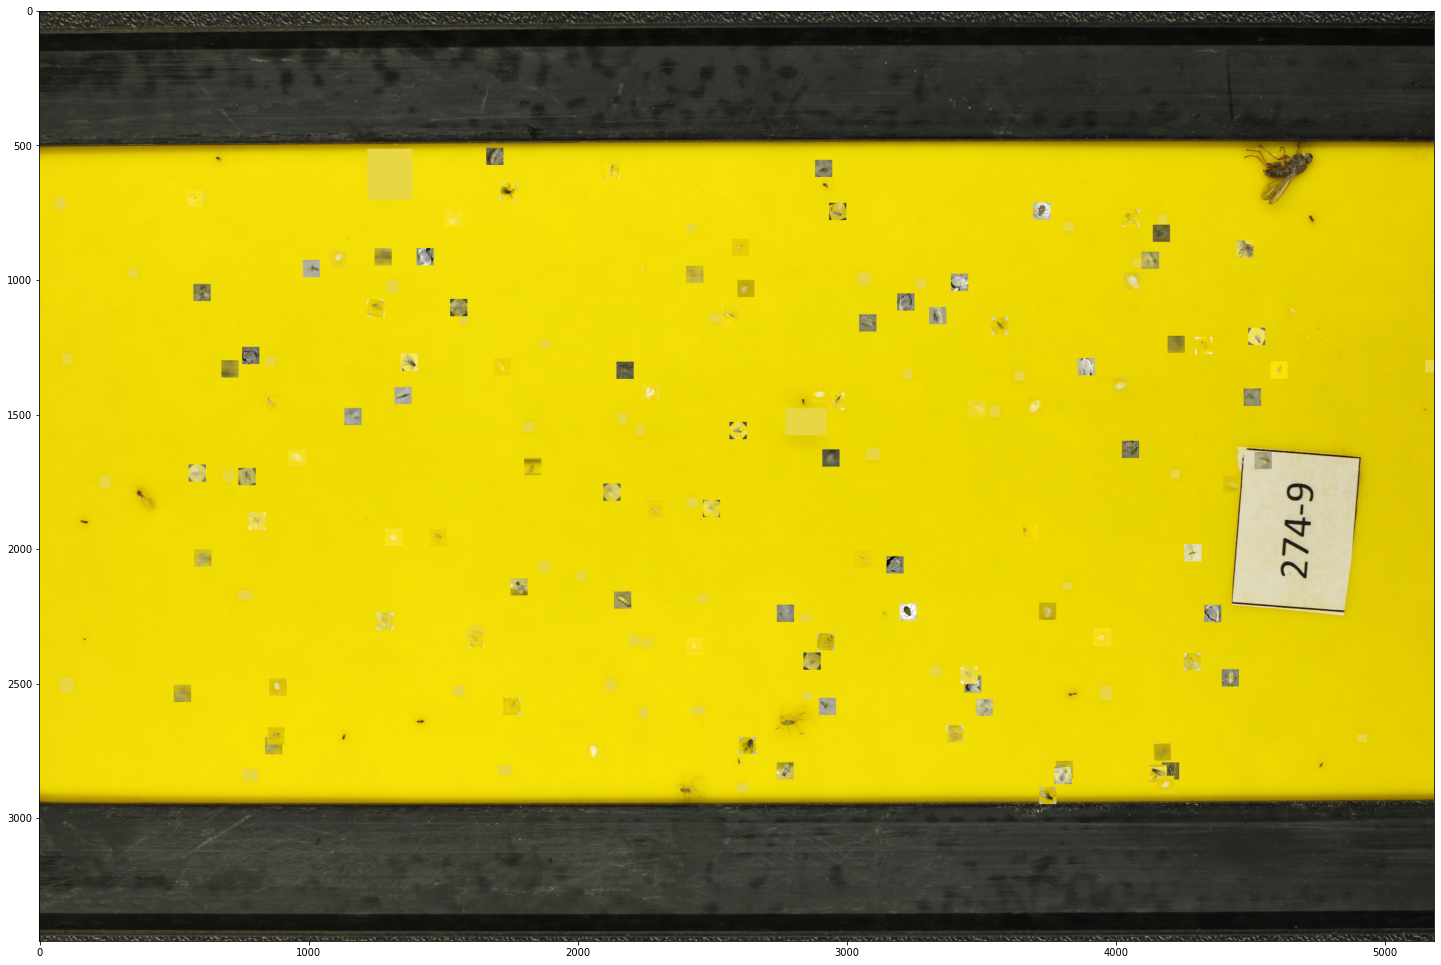

In [183]:
temp_img
plt.figure(figsize = (25,25))
plt.imshow(temp_img.permute(1, 2, 0))
plt.show()

In [212]:
save_image(temp_img, 'sample_recreation.jpg')